In [61]:
import cv2
import numpy as np
import scipy
import scipy.spatial
from cv2 import imread
import pickle 
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 特征提取
def extract_features(image_path, vector_size=100):
    image = imread(image_path)#imread函数从文件中加载图像并返回该图像
    try:
        # 可选的特征检测算法有 BRISK,AKAZE,KAZE 以及 ORB
        # 关键点检测
        # 特征检测算法
        alg = cv2.BRISK_create() 
        # alg = cv2.AKAZE_create()
        # alg = cv2.KAZE_create()
        # alg = cv2.ORB_create()
        
        #提取image的特征
        kps = alg.detect(image) 
        
        # 选取前 vector_size=32 个特征点
        # 特征点的个数取决于图像的大小以及颜色分布
        # 按照关键点响应值对特征点进行排序
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # 计算特征点上对应的特征向量
        kps, dsc = alg.compute(image, kps)
        
        # 将所有的特征向量组成一个大的特征值
        dsc = dsc.flatten()
        
        # 预定义一个维度为 64*vector_size 的特征向量
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # 如果计算得到的特征向量小于预定义的大小，则在向量末尾补零
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None
    return dsc

In [62]:
def batch_extractor(images_path, pickled_db_path="data/feature.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
# 将所有特征保存在 pickle 文件里
    with open(pickled_db_path, 'wb') as fp: # 以二进制写入
        pickle.dump(result, fp)

In [63]:
class Matcher(object):
    def __init__(self, pickled_db_path="data/feature.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp) #用于将二进制对象文件转换成 Python 对象
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)
    def cdist(self, vector):
        # 计算图像之间的 cosine 距离
        # 可选距离
        # chebyshev：切比雪夫距离
        # cityblock 街区距离
        # cosine：余弦夹角
        # mahalanobis：马氏距离
        # minkowski：闵可夫斯基距离
        # euclidean：欧式距离
        # hamming：汉明距离
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'hamming').reshape(-1)
    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cdist(features)
        # 找到排名前 5 的匹配结果
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()
        return nearest_img_paths, img_distances[nearest_ids].tolist() #tolist将矩阵转换成列表

In [64]:
def show_img(path):
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.show()

Extracting features from image data/images\1000.png
Extracting features from image data/images\1001.png
Extracting features from image data/images\1002.png
Extracting features from image data/images\1003.png
Extracting features from image data/images\1004.png
Extracting features from image data/images\1007.png
Extracting features from image data/images\1017.png
Extracting features from image data/images\1041.png
Extracting features from image data/images\1081.png
Query image ==========================================


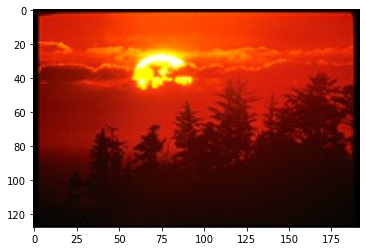

Result images ========================================
Match 0.41500000000000004


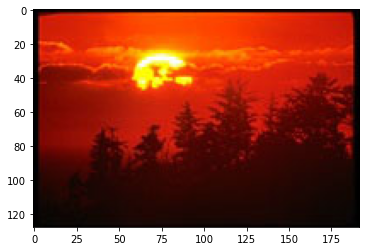

Match 0.37609375


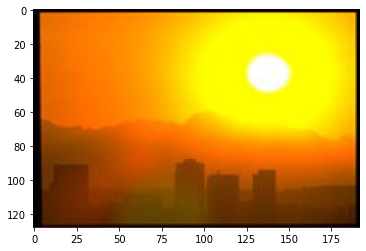

Match 0.35687500000000005


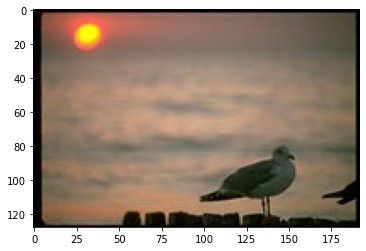

In [65]:
def run():
    images_path = 'data/images' 
    files = [os. path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # 打乱数据库中的图像顺序
    sample = random.sample(files, 3)
    batch_extractor(images_path)
    ma = Matcher('data/feature.pck')
    # 查询图像名称
    s = 'data/1.jpg' 
    print ('Query image ==========================================')
    show_img(s)
    names, match = ma.match(s, topn=3)
    print ('Result images ========================================' )
    for i in range(3):
    # 计算 cosine 距离，将相似性定义为 1-cosine 距离，当两个图像越近，此值相似指越高
        print ('Match %s' % (1-match[i]))
        show_img(os.path.join('data', names[i]))
run() #运行从这里开始